# Self-supervised Vision Transformer for Land Cover Classification and Segmentation: Swin Transformer + Sentinel-1/2 Demo

Linus Scheibenreif, Joëlle Hanna, [University of St.Gallen,  School of Computer Science, AIML Lab](https://ics.unisg.ch/chair-aiml-borth/)


This notebook contains sample code for fine-tuning of the pretrained Swin Transformer backbones from this work. The two backbones, utilizing Sentinel-1 SAR data and Sentinel-2 multi-band imaging, can be used separately or in a combined way. In this example, we will fine-tune the Swin Transformer backbones to an image classification task, utilizing both Sentinel-1 and Sentinel-2 data from the DFC2020 dataset. However, we would like to point out that the backbones are task agnostic and can be trained on any properly formatted Sentinel-1/2 dataset.

For further information, or to cite our work if you utilize this code, please refer to:

[Linus Scheibenreif, Joëlle Hanna, Michael Mommert, Damian Borth, *Self-Supervised Vision Transformers for Land-Cover Segmentation and Classification*, Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2022, pp. 1422-1431](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/html/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.html)

## Content

1. [Installation](#installation)
1. [Dataset](#dataset)
1. [Quick Start](#quickstart)

<a id='installation'></a>
## 1. Installation

First, start by cloning this repository:
```bash
git clone https://github.com/HSG-AIML/SSLTransformerRS.git
```

#### Dependencies

This project uses Python 3.8, and the dependencies listed in `requirements.txt` can be installed with `pip` or `conda`, in a virtual environment. For example, using `pip`:
```bash
pip install -r requirements.txt
```

In [1]:
# Import needed packages
import argparse
import json
import os
import random
import numpy as np
import torch
import wandb
import torch.nn.functional as F
from distutils.util import strtobool
from tqdm import tqdm
from torchvision.models import resnet18, resnet50
from utils import *
import rasterio
from pathlib import Path
import numpy as np
from torchvision import transforms
from Transformer_SSL.models.swin_transformer import DoubleSwinTransformerDownstream
from Transformer_SSL.models import build_model
import torch.nn as nn
from Transformer_SSL.models.swin_transformer import SwinTransformerDecoder

/home/bertille/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<a id='dataset'></a>
## 2. Dataset


#### Download

Any Sentinel-1 data, Sentinel-2 data or a fusion of both could be used. In this demo, we will use the DFC2020 dataset to train downstream tasks. You can download it using this [link](https://ieee-dataport.org/competitions/2020-ieee-grss-data-fusion-contest). We are using multimodal input here (fusion of Sentinel-1 and Sentinel-2) but keep in mind that a uni-modal input (Sentinel-1 only or Sentinel-2 only) can be used as well (you can see an example in the notebook `demo_resnet_backbone.ipynb`)



#### Configure 

For example, in the `data_config` dictionary (cell below), you can specify paths to the data directory with `train_dir` and `val_dir` or the image input size with `image_px_size`.

In [2]:
# Data configurations:
data_config = {
    'train_dir': '../../LandCover_map_Transformers_SSL/data/flair1_subset_13classes/train', # path to the training directory,  
    'val_dir': '../../LandCover_map_Transformers_SSL/data/flair1_subset_13classes/val', # path to the validation directory,
    'test_dir': '../../LandCover_map_Transformers_SSL/data/flair1_subset_13classes/test', # path to the validation directory,
    'train_mode': 'validation', # can be one of the following: 'test', 'validation'
    'val_mode': 'test', # can be one of the following: 'test', 'validation'
    'num_classes': 13, # number of classes in the dataset.
    'clip_sample_values': True, # clip (limit) values
    'train_used_data_fraction': 1, # fraction of data to use, should be in the range [0, 1]
    'val_used_data_fraction': 1,
    'image_px_size': 224, # image size (224x224)
    'cover_all_parts_train': True, # if True, if image_px_size is not 224 during training, we use a random crop of the image
    'cover_all_parts_validation': True, # if True, if image_px_size is not 224 during validation, we use a non-overlapping sliding window to cover the entire image
    'seed': 42,
}

In [3]:
# Ensure deterministic behavior
random.seed(data_config['seed'])
np.random.seed(data_config['seed'])
torch.manual_seed(data_config['seed'])
torch.cuda.manual_seed_all(data_config['seed'])

#### Prepare

We create the `train_dataset` and `val_dataset` by using the `DFCDataset`, a custom class of `torch.utils.data.Dataset`

In [4]:
class Flair1Dataset_SSL(torch.utils.data.Dataset):
    def __init__(self, folder_path, size = 256, multimodal = False, seed = 42):
        super(Flair1Dataset_SSL, self).__init__()
        self.resize_transform = transforms.Resize((size, size))
        self.resize_transform_l = transforms.Resize((size, size), interpolation=transforms.InterpolationMode.NEAREST)
        self.folder_path = folder_path
        self.img_files = sorted(list(get_data_paths(Path(self.folder_path), 'image*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.mask_files = sorted(list(get_data_paths(Path(self.folder_path), 'mask*.tif')), key=lambda x: int(x.split('_')[-1][:-4]))
        self.total = len(self.img_files)
        self.n_classes = len(dict_classes)
        self.multimodal = multimodal
        if multimodal == False:
            self.n_inputs = 3
        else: 
            self.n_inputs_rgb = 3
            self.n_inputs_ir_el = 2

    def __len__(self):
        return self.total

    def __getitem__(self, idx):
        img = {}
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]

        label = rasterio.open(mask_path).read()
        label = label - 1

        data = rasterio.open(img_path).read()
        img['rgb'] = data[0:3,:, :]
        img['rgb'] = np.transpose(img['rgb'], (1, 2, 0))
        img['rgb'] = transforms.ToPILImage()(img['rgb'])
        img['rgb'] = self.resize_transform(img['rgb'])
        # Convert back to tensor
        img['rgb'] = transforms.ToTensor()(img['rgb'])

        img['ir_el'] = data[3:,:, :]
        img['ir_el'] = np.transpose(img['ir_el'], (1, 2, 0))
        img['ir_el'] = transforms.ToPILImage()(img['ir_el'])
        img['ir_el'] = self.resize_transform(img['ir_el'])
        # Convert back to tensor
        img['ir_el'] = transforms.ToTensor()(img['ir_el'])

        # Convert label to PIL Image for resizing
        label = np.transpose(label, (1, 2, 0))
        label = transforms.ToPILImage()(label)
        label = self.resize_transform_l(label)
        #print values uniques in label
        # Convert back to tensor
        label = torch.from_numpy(np.array(label, dtype=np.uint8))
        label = label.long()

        #Turn data and label into float between 0 and 1
        # data = data / 255
        # label = label / 255
        return img, label

    def get_per_per_class(self):
        class_per = dict.fromkeys(range(1,14), 0)
        total_pixels = 0
        for i in range(len(self)):
            _, label = self[i]
            for j in range(1,13):
                class_per[j] += torch.sum(label == j).item()
            total_pixels += label.numel()
        for j in range(1,14):
            class_per[j] = class_per[j] / total_pixels
        return class_per

In [5]:
#from dfc_dataset import DFCDataset
size = 224
multimodal = True
train_dataset = Flair1Dataset_SSL(data_config['train_dir'], size, multimodal)
val_dataset = Flair1Dataset_SSL(data_config['val_dir'], size, multimodal)
test_dataset = Flair1Dataset_SSL(data_config['test_dir'], size, multimodal)

'''# Create Training Dataset
train_dataset = DFCDataset(
    data_config['train_dir'],
    mode=data_config['train_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['train_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_train'],
    seed=data_config['seed'],
)

# Create Validation Dataset
val_dataset = DFCDataset(
    data_config['val_dir'],
    mode=data_config['val_mode'],
    clip_sample_values=data_config['clip_sample_values'],
    used_data_fraction=data_config['val_used_data_fraction'],
    image_px_size=data_config['image_px_size'],
    cover_all_parts=data_config['cover_all_parts_validation'],
    seed=data_config['seed'],
)'''

"# Create Training Dataset\ntrain_dataset = DFCDataset(\n    data_config['train_dir'],\n    mode=data_config['train_mode'],\n    clip_sample_values=data_config['clip_sample_values'],\n    used_data_fraction=data_config['train_used_data_fraction'],\n    image_px_size=data_config['image_px_size'],\n    cover_all_parts=data_config['cover_all_parts_train'],\n    seed=data_config['seed'],\n)\n\n# Create Validation Dataset\nval_dataset = DFCDataset(\n    data_config['val_dir'],\n    mode=data_config['val_mode'],\n    clip_sample_values=data_config['clip_sample_values'],\n    used_data_fraction=data_config['val_used_data_fraction'],\n    image_px_size=data_config['image_px_size'],\n    cover_all_parts=data_config['cover_all_parts_validation'],\n    seed=data_config['seed'],\n)"

We can see how many examples are in each split by checking their length:

In [6]:
len(train_dataset), len(val_dataset)

(51, 11)

In [7]:
#loop on train_ds and check shape of rgb and ir_el
rgb = train_dataset[0][0]['rgb']
ir_el = train_dataset[0][0]['ir_el']
print(rgb.shape)
print(ir_el.shape)

torch.Size([3, 224, 224])
torch.Size([2, 224, 224])


We define a correspondance of label and names:

In [8]:
dict_classes = {
1   : 'building',
2   : 'pervious surface',
3   : 'impervious surface',
4   : 'bare soil',
5   : 'water',
6   : 'coniferous',
7   : 'deciduous',
8   : 'brushwood',
9   : 'vineyard',
10  : 'herbaceous vegetation',
11  : 'agricultural land',
12  : 'plowed land',
13  : 'other'}

Our data is now ready to be used by the model. In the next section we load and configure the model. 

<a id='quickstart'></a>
## 3. Quick Start

#### Configure 

You can specify in the some hyperparameters in `train_config` (cell below), such as the `learning_rate`, the `batch_size`, number of `epochs`, or if you wish to fine-tune the model or not (with the `finetuning` argument), etc.

In [9]:
# Training configurations
train_config = {
    's1_input_channels': 2,
    's2_input_channels': 13,
    'finetuning': False, # If false, backbone layers is frozen and only the head is trained
    'classifier_lr': 3e-6,
    'learning_rate': 0.00001,
    'adam_betas': (0.9, 0.999), 
    'weight_decay': 0.001,
    'dataloader_workers': 4,
    'batch_size': 2,#16
    'epochs': 5, 
    'target': 'dfc_label'
}

#### Download checkpoint

You can download the pre-trained backbone model using this [link](https://drive.google.com/file/d/1e7QhC2-zoBFgb65yN1ADWBZLMShHOweY/view), save it in the `checkpoints/` directory then run the following cell.

Make sure to properly modify the path to the downloaded checkpoint in the path below.

In the case where you are using a uni-modal dataset (Sentinel-2 only or Sentinel-1 only), you can load the corresponding weight stream `s1_weights` or `s2_weights`, and comment the other one.

In [10]:
# path to the checkpoint
checkpoint = torch.load(
    "models/swin_t.pth", map_location=torch.device('cpu') #comment map_location if using GPU
) 
weights = checkpoint["state_dict"]

# Sentinel-1 stream weights
s1_weights = {
    k[len("backbone1."):]: v for k, v in weights.items() if "backbone1" in k
}

# Sentinel-2 stream weights
s2_weights = {
    k[len("backbone2."):]: v for k, v in weights.items() if "backbone2" in k
}

#### Prepare model and load checkpoint

We prepare the model by specifying the `input_channels`: only sentinel1, only sentinel2 or both. We also specify if we need both backbones `s1_backbone` and `s2_backbone` depending on our application. In the case where only one stream is needed, just comment the lines `s1_backbone` or `s2_backbone`.

In [11]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def dotdictify(d):
    """recursively wrap a dictionary and
    all the dictionaries that it contains
    with the dotdict class
    """
    d = dotdict(d)
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = dotdictify(v)
    return d

In [12]:

#from utils_SSL import save_checkpoint_single_model, dotdictify

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu:0")

# Input channel size
input_channels = 3#train_config['s1_input_channels'] + train_config['s2_input_channels']

# If you are using a uni-modal dataset, you can un-comment one of these lines, and comment the one above:
# input_channels = train_config['s1_input_channels']
# input_channels = train_config['s2_input_channels']

with open("configs/backbone_config.json", "r") as fp:
    swin_conf = dotdictify(json.load(fp))

s1_backbone = build_model(swin_conf.model_config)

swin_conf.model_config.MODEL.SWIN.IN_CHANS = 13
s2_backbone = build_model(swin_conf.model_config)

s1_backbone.load_state_dict(s1_weights)
s2_backbone.load_state_dict(s2_weights)

/home/bertille/miniconda3/envs/env_pytorch/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [13]:
# get information about loaded models
print("S1 backbone:", s1_backbone)
print("S2 backbone:", s2_backbone)

S1 backbone: SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (no

We create the downstream model head that will be trained. In this demo, we will train a classifier. You can find a segmentation head in the repository (/TransformerSSL/models/swin_transformer/DoubleSwinTransformerSegmentation). Our classifier takes as input the pre-trained backbone (in the form of two streams `encoder1` and `encoder2`), the `out_dim` (number of classes), and `freeze_layers` flag, specifying whether you wish to freeze the backbone weights or not.

In [14]:
class DoubleSwinTransformerSegmentation(nn.Module):
    def __init__(self, encoder1, encoder2, out_dim, device, freeze_layers=False):
        super(DoubleSwinTransformerSegmentation, self).__init__()

        self.device = device

        self.backbone1 = encoder1
        self.backbone2 = encoder2

        self.decoder1 = SwinTransformerDecoder(self.backbone1, out_dim, device)
        self.decoder2 = SwinTransformerDecoder(self.backbone2, out_dim, device)

        # freeze all backbone layers
        if freeze_layers:
            for name, param in self.named_parameters():
                if name.startswith(('backbone')):
                    param.requires_grad = False

        self.expand_channels = torch.nn.Conv2d(3, 13, kernel_size=1, stride=1, padding=0) 

    def forward(self, x):
        expanded_rgb = self.expand_channels(x["rgb"].to(self.device))
        _, x2, x_seg2 = self.backbone2.forward_features(expanded_rgb)

        _, x1, x_seg1 = self.backbone1.forward_features(x["ir_el"].to(self.device))

        x1 = self.decoder1.forward_up_features(x1, x_seg1)
        x2 = self.decoder2.forward_up_features(x2, x_seg2)

        x = torch.cat([x1, x2], dim=-1)

        output = self.decoder1.up_x4(x)

        return output

In [15]:
model = DoubleSwinTransformerSegmentation(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device
    )

model = model.to(device)

Define and initialise the loss for training. Here we are training for single-class classification and using a `torch.nn.CrossEntropyLoss` loss. 

In [16]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255, reduction="mean").to(device)

Define the trainable parameters (needed for the optimizer):

In [17]:
if train_config['finetuning']:
    # train all parameters (backbone + classifier head)
    param_backbone = []
    param_head = []
    for p in model.parameters():
        if p.requires_grad:
            param_head.append(p)
        else:
            param_backbone.append(p)
        p.requires_grad = True
    # parameters = model.parameters()
    parameters = [
        {"params": param_backbone},  # train with default lr
        {
            "params": param_head,
            "lr": train_config['classifier_lr'],
        },  # train with classifier lr
    ]
    print("Finetuning")

else:
    # train only final linear layer for SSL methods
    print("Frozen backbone")
    parameters = list(filter(lambda p: p.requires_grad, model.parameters()))

Frozen backbone


Initialise the selected optimizer. In this work we chose Adam optimizer. You can initialise any optimizer you want. 

In [18]:
optimizer = torch.optim.Adam(
    parameters,
    lr=train_config['learning_rate'],
    betas=train_config['adam_betas'],
    weight_decay=train_config['weight_decay'],
)

We load the data (training and validation) using pytorch's dataloader 

In [19]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=train_config['dataloader_workers'],
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=train_config['batch_size'],
    shuffle=False,
    num_workers=train_config['dataloader_workers'],
)

Everything is set and we are now ready to train the classifier head:

In [20]:
from metrics import PixelwiseMetrics
from validation_utils import validate_all

step = 0

# Training loop

for epoch in range(train_config['epochs']):
    # Model Training
    model.train()
    step += 1

    pbar = tqdm(train_loader)

    # track performance
    epoch_losses = torch.Tensor()
    metrics = PixelwiseMetrics(data_config['num_classes'])

    for idx, (img, y) in enumerate(pbar):        
        # load target
        y = y.to(device)
        # model output
        y_hat = model(img)
        
        # loss computation
        loss = criterion(y_hat, y)
        
        # backward step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # get prediction 
        _, pred = torch.max(y_hat, dim=1)

        epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
        metrics.add_batch(y, pred)

        pbar.set_description(f"Epoch:{epoch}, Training Loss:{epoch_losses[-100:].mean():.4}")

    mean_loss = epoch_losses.mean()

    train_stats = {
            "train_loss": mean_loss.item(),
            "train_average_accuracy": metrics.get_average_accuracy(),
            "train_overall_accuracy": metrics.get_average_accuracy(),
            **{
                "train_accuracy_" + k: v
                for k, v in metrics.get_classwise_accuracy().items()
            },
        }
    print(train_stats)

    if epoch % 2 == 0:  

        # Model Validation
        model.eval()
        pbar = tqdm(val_loader)

        # track performance
        epoch_losses = torch.Tensor()
        metrics = PixelwiseMetrics(data_config['num_classes'])

        with torch.no_grad():
            for idx, (img, y) in enumerate(pbar):        
                y = y.to(device)
                # model output
                y_hat = model(img)

                # loss computation
                loss = criterion(y_hat, y)

                # get prediction 
                _, pred = torch.max(y_hat, dim=1)

                epoch_losses = torch.cat([epoch_losses, loss[None].detach().cpu()])
                metrics.add_batch(y, pred)


                pbar.set_description(f"Validation Loss:{epoch_losses[-100:].mean():.4}")

            mean_loss = epoch_losses.mean()

            val_stats = {
                "validation_loss": mean_loss.item(),
                "validation_average_accuracy": metrics.get_average_accuracy(),
                "validation_overall_accuracy": metrics.get_average_accuracy(),
                **{
                    "validation_accuracy_" + k: v
                    for k, v in metrics.get_classwise_accuracy().items()
                },
            }

            print(f"Epoch:{epoch}", val_stats)
            
            # Save model checkpoint every 2 epochs 
            if epoch % 2 == 0:
                if epoch == 0:
                    continue

                save_weights_path = (
                    "checkpoints/" + "-".join(["classifier", "epoch", str(epoch)]) + ".pth"
                )
                torch.save(model.state_dict(), save_weights_path)


  0%|          | 0/26 [00:00<?, ?it/s]

/home/bertille/Documents/A23/MVA_cours_S1/Object_recognition_CV/project/LandCover_map_Transformers_SSL/src/metrics.py:162: RuntimeWarning: invalid value encountered in true_divide
  class_data["acc"] += num_correct / num_pixels
Epoch:0, Training Loss:2.615: 100%|██████████| 26/26 [06:29<00:00, 14.98s/it]


{'train_loss': 2.615051031112671, 'train_average_accuracy': nan, 'train_overall_accuracy': nan, 'train_accuracy_pixelclass_0': nan, 'train_accuracy_pixelclass_1': nan, 'train_accuracy_pixelclass_2': nan, 'train_accuracy_pixelclass_3': nan, 'train_accuracy_pixelclass_4': nan, 'train_accuracy_pixelclass_5': nan, 'train_accuracy_pixelclass_6': nan, 'train_accuracy_pixelclass_7': nan, 'train_accuracy_pixelclass_8': nan, 'train_accuracy_pixelclass_9': nan, 'train_accuracy_pixelclass_10': nan, 'train_accuracy_pixelclass_11': nan, 'train_accuracy_pixelclass_12': nan}


Validation Loss:2.426: 100%|██████████| 6/6 [00:25<00:00,  4.22s/it]


Epoch:0 {'validation_loss': 2.4264094829559326, 'validation_average_accuracy': nan, 'validation_overall_accuracy': nan, 'validation_accuracy_pixelclass_0': nan, 'validation_accuracy_pixelclass_1': nan, 'validation_accuracy_pixelclass_2': nan, 'validation_accuracy_pixelclass_3': nan, 'validation_accuracy_pixelclass_4': nan, 'validation_accuracy_pixelclass_5': nan, 'validation_accuracy_pixelclass_6': nan, 'validation_accuracy_pixelclass_7': nan, 'validation_accuracy_pixelclass_8': nan, 'validation_accuracy_pixelclass_9': 0.2817716142039283, 'validation_accuracy_pixelclass_10': nan, 'validation_accuracy_pixelclass_11': nan, 'validation_accuracy_pixelclass_12': nan}


  0%|          | 0/26 [00:00<?, ?it/s]

: 

You can evaluate the model on one example by creating a model's instance, loading checkpoint's weights of the classifier saved during training, running it, and displaying the results:

Predicted class: Croplands
Ground-truth class:  Croplands


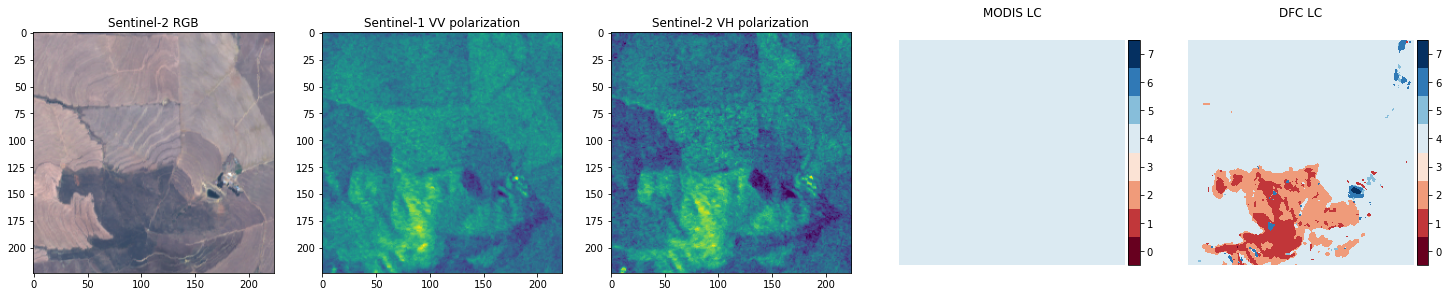

In [19]:
# create a new model's instance
model = DoubleSwinTransformerClassifier(
        s1_backbone, s2_backbone, out_dim=data_config['num_classes'], device=device)

model = model.to(device)

# load checkpoints weights
model.load_state_dict(torch.load("checkpoints/classifier-epoch-4.pth"))

# prepare input and feed it to model for evaluation
img = {"s1": torch.unsqueeze(val_dataset[2]['s1'], 0), "s2": torch.unsqueeze(val_dataset[2]['s2'], 0)} # adding an extra dimension for batch information
model.eval()
output = model(img)

# display predicted class:
print(f'Predicted class: {dict_classes[torch.argmax(output).item()]}')

# display ground-truth label:
print('Ground-truth class: ', dict_classes[val_dataset[2][train_config['target']]])

# display image
val_dataset.visualize_observation(2)